<a href="https://colab.research.google.com/github/AndresMontesDeOca/RegresionAvanzada/blob/main/TrabajoPractico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Instalacion de Librerias

In [ ]:
# Instalacion de Paquetes
!pip install pingouin # No incluido en Google Colab
# !pip install scipy
# !pip install statsmodels

# Version rpy2 que no tiene problemas de compatibilidad
!pip install rpy2==3.5.1

# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1, color_codes=True)

# Recursion limit errors with R Magic
import sys
# sys.setrecursionlimit(50000)

# Activamos R magic
%load_ext rpy2.ipython

#### Carga de Datos desde Goolge Drive

In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Grasa de Cerdos
id = '153lGVzdixcHT-keKg8qmvaoWdPHg6_tB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('grasacerdos.xlsx')
dataG = pd.read_excel('grasacerdos.xlsx', index_col='Obs') # Cargamos el Dataset
dataG = dataG.replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
dataG = dataG.astype('float') # Transformo en float
%R -i dataG
######################################################
# Peso, Edad, Colesterol
id = '17Dv1WcWlc9ojWa6bnSfD7TCRaVKCKqj0'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('peso_edad_colest.xlsx')
dataP = pd.read_excel('peso_edad_colest.xlsx')
%R -i dataP

In [74]:
%%R

### MVN Henze-Zirkler Test ### -> Lento
# # system(sudo apt install libgsl-dev)
# install.packages('MVN')

# # Wald Test ### -> Rapido
# install.packages('aod')

# # QQ Plot, Bonferroni ### -> Lento
# install.packages('car')

# # LRM Tests ### -> Rapido
# install.packages('lmtest')

# ## Box-Cox Transformation ### -> Rapido
# install.packages('MASS')


####################################
### Installation Status ###
# print(system.file(package='MVN'))

(as ‘lib’ is unspecified)














	‘/tmp/RtmpGV5bTy/downloaded_packages’



# Capitulo I: Regresion Lineal Simple

## Ejercicio 1.1 - Correlacion

In [4]:
# Dataset Grasa de cerdos
data = dataG
display(dataG.head())

,PV,EGD
Obs,,
1,56.81,16.19
2,70.40,22.00
3,71.73,19.52
4,75.10,31.00
5,79.65,23.58


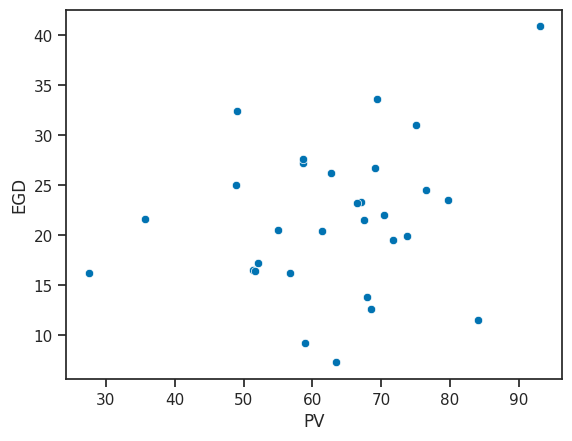

In [5]:
# Punto a -> Scatterplot e interpretacion
sns.scatterplot(data=data, x='PV', y='EGD')
plt.show()

a) No se observa patron de asociacion lineal en el grafico de dispersion

In [6]:
# Calculo del Coeficiente de Correlacion
# display(data.head())
display(pg.corr(data.PV, data.EGD, method='pearson'))
display(pg.corr(data.PV, data.EGD, method='spearman'))
display(pg.corr(data.PV, data.EGD, method='kendall'))

# Verificacion de Normalidad de las Variables
print('\n', pg.normality(data.PV))
print('\n', pg.normality(data.EGD))
print('\n', pg.multivariate_normality(data)) # Henze-Zirkler Test, H0 -> Multiv Normal Dist


,n,r,CI95%,p-val,BF10,power
pearson,30,0.254343,"[-0.12, 0.56]",0.174994,0.546,0.27791


,n,r,CI95%,p-val,power
spearman,30,0.166185,"[-0.21, 0.5]",0.380118,0.142724


,n,r,CI95%,p-val,power
kendall,30,0.112644,"[-0.26, 0.45]",0.395032,0.091095



            W      pval  normal
PV  0.975331  0.692481    True

             W      pval  normal
EGD  0.985135  0.939467    True

 HZResults(hz=0.25394365632841115, pval=0.9049686197809698, normal=True)


- b) Los Coeficientes de Correlacion no son significativos, se observa que los todos los IC de los distintos tests incluyen el 0
- c) No hay suficiente evidencia para rechazar el supuesto de Normalidad Bivariada

## Ejercicio 1.2 - Modelo Lineal Simple

In [12]:
# Dataset de Colesterol, Peso y Edad
data = dataP
data.head()

,peso,edad,colest
0,84,46,354
1,73,20,190
2,65,52,405
3,70,30,263
4,76,57,451


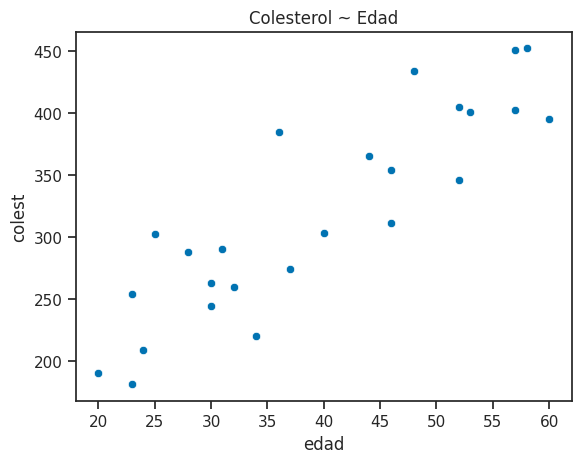

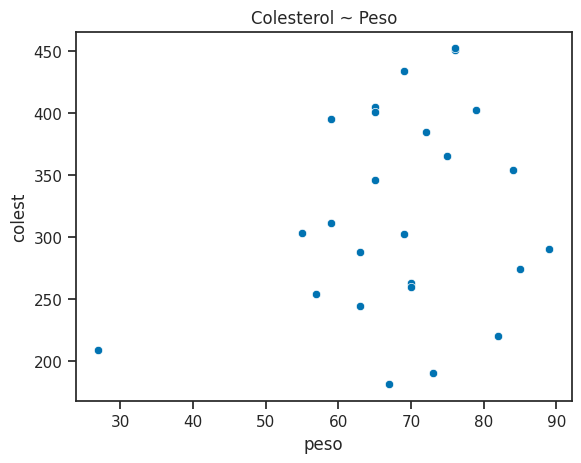

In [16]:
# Diagramas de Dispersion
sns.scatterplot(data=data, x='edad', y='colest')
plt.title('Colesterol ~ Edad')
plt.show()

sns.scatterplot(data=data, x='peso', y='colest')
plt.title('Colesterol ~ Peso')
plt.show()

a) Si, pareciera existir una relacion lineal entre Peso y Colesterol

In [26]:
# Generamos el modelo lineal en R
%%R
data <- dataP

model = lm('colest ~ edad', data=data)
# print(summary(model))
print(model$coef)

(Intercept)        edad 
  95.502004    5.670842 


- b)  El coeficiente de la variable independiente edad es de 5.67 y el de la ordenada al origen 95.5

In [37]:
%%R

# Modelo
print(summary(model))

# Test Wald
library(aod)
wald.test(Sigma = vcov(model), b = coef(model), Terms = 1) # Cuerpo| H0: Coef = 0 (Var no significativa)


Call:
lm(formula = "colest ~ edad", data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-68.311 -22.602  -2.627  27.589  85.348 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  95.5020    26.2545   3.638  0.00138 ** 
edad          5.6708     0.6345   8.937 6.09e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 39.69 on 23 degrees of freedom
Multiple R-squared:  0.7764,	Adjusted R-squared:  0.7667 
F-statistic: 79.87 on 1 and 23 DF,  p-value: 6.094e-09

Wald test:
----------

Chi-squared test:
X2 = 13.2, df = 1, P(> X2) = 0.00028


- c) Tanto el test del modelo, como el test de Wald de la varible independiente indican que ambos son significativos

In [56]:
# Predicciones
data = dataP
print(data.edad.max())

60


In [65]:
# predichos <- predict(object=model, interval='prediction', level=0.95)
# Creo los datos a predecir
to_predict = [25, 48]
newdata = pd.Series(to_predict, name='edad').to_frame()

# Los exporto a R
%R -i newdata

In [69]:
%%R

predict(object=model, newdata=newdata, interval='confidence')

       fit      lwr      upr
0 237.2730 212.1954 262.3507
1 367.7024 347.8058 387.5990


- d) 237.27 y 367.7 de Colesterol para 25 y 48 anos respectivamente. Para 80 anos no deberia estimarse, ya que esta fuera del dominio del modelo


	Shapiro-Wilk normality test

data:  model$resid
W = 0.96478, p-value = 0.5175



 7 19 
 8 20 


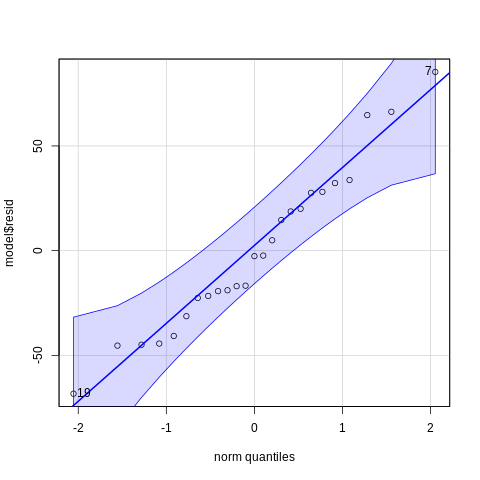

In [73]:
%%R

# Normalidad de Residuos Analitica
print(shapiro.test(model$resid))

# Normalidad de residuos grafica
library(car)
qqPlot(model$resid)

- e1) No hay suficiente evidencia para rechazar el supuesto de Normalidad de los residuos

In [88]:
# # Residuals Variance (Homosedasticity)
# Analisis Analitico (Breusch-Pagan Test) -> R | H0: Residuos Homocedasticos
%%R

library(lmtest)
print(bptest(model))

resid = model$resid
fitted = model$fitted.values


	studentized Breusch-Pagan test

data:  model
BP = 0.15821, df = 1, p-value = 0.6908



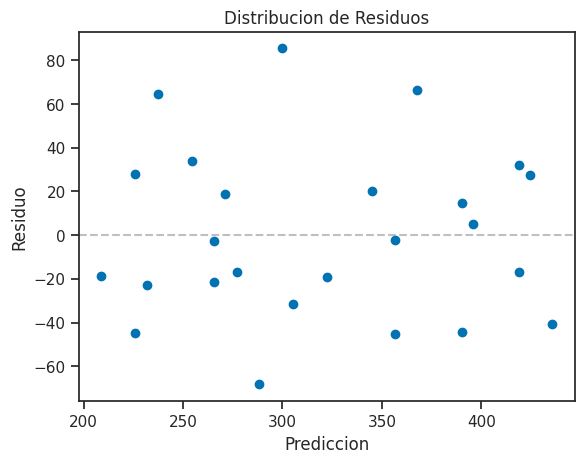

In [86]:
# # Analsis Grafico -> Python

# Importo Datos desde R
%R -o resid
%R -o fitted

plt.scatter(x=fitted, y=resid)
plt.xlabel( 'Prediccion')
plt.ylabel('Residuo')
plt.title('Distribucion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura de embudo

- e2) Tampoco hay suficiente evidencia para rechazar su homocedasticidad. En el analisis grafico no se observa la forma de "embudo"